<a href="https://colab.research.google.com/github/alex-bolshunov/data_mining_project/blob/main/data_mining_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [511]:
#columns: npi, gender, state, dredentials, speciality, opiods, non opiods, risk skale (overdose / population) ?
#https://www.kaggle.com/datasets/apryor6/us-opiate-prescriptions/data?select=overdoses.csv

In [512]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [513]:
#get data
!curl "https://raw.githubusercontent.com/alex-bolshunov/Data_mining_project/main/prescriber_info.csv" -o prescriber.csv
!curl "https://raw.githubusercontent.com/alex-bolshunov/Data_mining_project/main/overdoses.csv" -o overdose.csv
!curl "https://raw.githubusercontent.com/alex-bolshunov/datasets/refs/heads/main/type_of_meds.csv" -o type_of_meds.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.7M  100 13.7M    0     0  21.6M      0 --:--:-- --:--:-- --:--:-- 21.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1789  100  1789    0     0  12760      0 --:--:-- --:--:-- --:--:-- 12778
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4149  100  4149    0     0  28299      0 --:--:-- --:--:-- --:--:-- 28417


In [514]:
#type of meds
meds_types = pd.read_csv("type_of_meds.csv")

In [515]:
#sorting by type
meds_types.sort_values("Type", inplace=True)

#setting new index
new_index = list(range(len(meds_types)))
meds_types['index'] = new_index
meds_types.set_index('index', inplace = True)

In [516]:
#get indecies of rows for each group
meds_indicies = meds_types.loc[:, "Type"].value_counts().cumsum()

In [517]:
#overdose df
overdose_df = pd.read_csv("overdose.csv")

In [518]:
overdose_column_names = ["state_full", "pop", "od", "state"]
overdose_df_types = {
    overdose_column_names[1]: "int32",
    overdose_column_names[2]: "int32",
}

In [519]:
#renaming columns
overdose_df.columns = overdose_column_names

In [520]:
#removing comas
num_columns_to_clean = ["pop", "od"]
overdose_df[num_columns_to_clean] = overdose_df[num_columns_to_clean].map(lambda s: s.replace(",", ""))

In [521]:
#changing datatype
overdose_df = overdose_df.astype(overdose_df_types)

In [522]:
#subset three columns, remove full state name column
#overdose_df = overdose_df.loc[:, overdose_column_names[1:]]

In [523]:
#create new variable overdose ratio (overdose / populaiton)
overdose_df["od.ratio"] =  (overdose_df["od"]/overdose_df["pop"]*100)

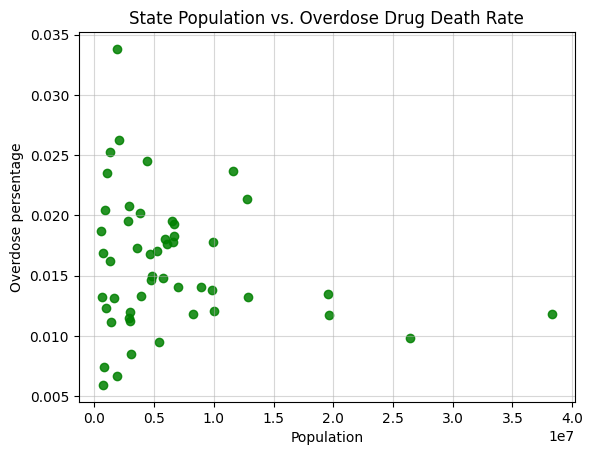

In [525]:
#instead of ratio we can use two
x = overdose_df.loc[:, "pop"]
y = overdose_df.loc[:, "od.ratio"]

fig, ax = plt.subplots()
ax.scatter(x, y, alpha = 0.85, color = "green")
ax.set_xlabel("Population")
ax.set_ylabel("Overdose persentage")
ax.set_title("State Population vs. Overdose Drug Death Rate")
ax.grid(alpha = 0.5)
plt.savefig("state_population vs. Overdose Drug Death Rate")

In [474]:
def addlabels(x,y, rn = 3):
    for i in range(len(x)):
        plt.text(i, y[i]/2, np.round(y[i], rn), ha = 'center', va ="center", zorder = 10)

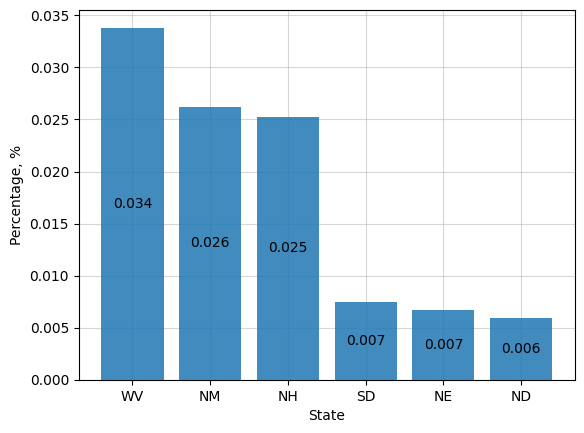

In [475]:
t = overdose_df.sort_values("od.ratio", ascending = False).iloc[:3, :]
t = pd.concat([t, overdose_df.sort_values("od.ratio", ascending = False).iloc[47:, :]], ignore_index = False)
x = t.loc[:, "state"]
y = t.loc[:, "od.ratio"]

plt.bar(x = x, height = y, zorder = 5, alpha = 0.85)
addlabels(t.loc[:, "state"].to_list(), t.loc[:, "od.ratio"].to_list())
plt.ylabel("Percentage, %")
plt.xlabel("State")
plt.grid(alpha = 0.5)

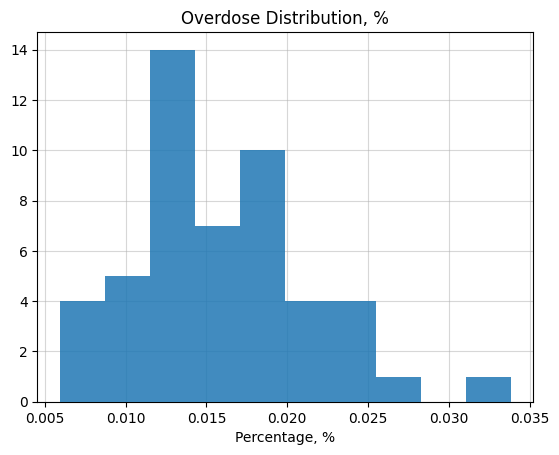

In [510]:
hist_pars = { "alpha": 0.85, "zorder": 5}

plt.hist(overdose_df.loc[:, "od.ratio"], **hist_pars)
plt.title("Overdose Distribution, %")
plt.xlabel("Percentage, %")
plt.grid(alpha = 0.5)

In [477]:
#summary statistics overdose persentage state level
pd.concat([overdose_df["od.ratio"].describe().reset_index(), overdose_df["od.ratio"].agg(["median"]).reset_index()], ignore_index = True).set_index("index")

,od.ratio
index,
count,50.000000
mean,0.015944
std,0.005467
min,0.005944
25%,0.012040
50%,0.014906
75%,0.019121
max,0.033813
median,0.014906


In [478]:
#define the group based on the number
def categorize(num):
  available_groups = "ABC"
  selected_group = ""

  if(num < 0.01): selected_group = available_groups[2]
  elif(num < 0.02): selected_group = available_groups[1]
  else: selected_group = available_groups[0]

  return selected_group

In [479]:
#create variabe od group
overdose_df["od.group"] = overdose_df["od.ratio"].apply(categorize)

In [480]:
#check value counts
overdose_df["od.group"].value_counts().sort_index()

,count
od.group,
A,10
B,34
C,6


In [481]:
overdose_df.iloc[25:30]

,state_full,pop,od,state,od.ratio,od.group
25,Montana,1015165,125,MT,0.012313,B
26,Nebraska,1868516,125,NE,0.006690,C
27,Nevada,2790136,545,NV,0.019533,B
28,New Hampshire,1323459,334,NH,0.025237,A
29,New Jersey,8899339,1253,NJ,0.014080,B


In [482]:
#testing values
groups = "ABC"
groups_states_dict = {}

#populate dict state:group pairs
for char in groups:
  groups_states_dict.update({
     key:char for key in overdose_df[overdose_df["od.group"] == char]["state"].to_list()
  })

#check if the state in correct group
def check_group(state, group):
  if(group != groups_states_dict.get(state, "")): raise Exception("Group doesn't match")

#loop over values check each pair
def test1(df):
  for state, group in list(df[['state', "od.group"]].itertuples(index=False, name=None)): check_group(state, group)
  print("Test completed")


In [483]:
#prescriber df
prescriber_df = pd.read_csv("prescriber.csv")

p_df = prescriber_df.copy()

In [484]:
prescriber_df.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [485]:
#reordering columns accoring to each group
p_cols = prescriber_df.columns.to_list()
p_cols_sorted = list(meds_types.loc[:, "Name"].values)
new_cols = p_cols[:5] + p_cols_sorted + p_cols[len(p_cols) - 1:]
prescriber_df = prescriber_df.loc[:, new_cols]

In [486]:
notodf = prescriber_df.iloc[:, 5:meds_indicies[0] + 5].sum().sort_values(ascending = False).reset_index()
notodf.columns = ["name", "quantity"]
notodf.loc[:, "ratio"] = notodf.loc[:, "quantity"] / sum(notodf.loc[:, "quantity"])
notodf.head(5)

,name,quantity,ratio
0,LISINOPRIL,1176243,0.038082
1,LEVOTHYROXINE.SODIUM,1144724,0.037062
2,AMLODIPINE.BESYLATE,1107865,0.035868
3,SIMVASTATIN,1032511,0.033429
4,OMEPRAZOLE,1012238,0.032772


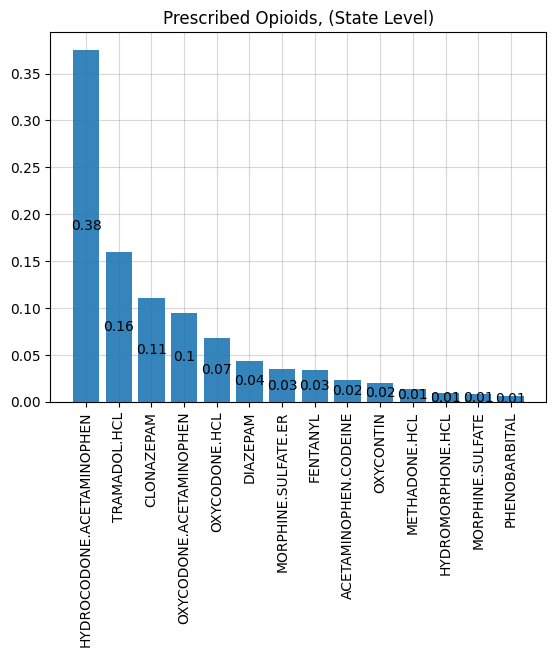

In [487]:
odf = prescriber_df.iloc[:, meds_indicies[0] + 5:meds_indicies[1] + 5].sum().sort_values(ascending = False).reset_index()
odf.columns = ["name", "quantity"]
odf.loc[:, "ratio"] = odf.loc[:, "quantity"] / sum(odf.loc[:, "quantity"])
x = odf.loc[:, "name"].to_list()
y = odf.loc[:, "ratio"].to_list()

plt.bar(x, y, zorder = 5, alpha = 0.9)
plt.xticks(rotation = 90)
plt.title("Prescribed Opioids by Drug Name, (State Level)")
plt.ylabel("Persantage, %")
addlabels(x, y, 2)
plt.grid(alpha = 0.5)

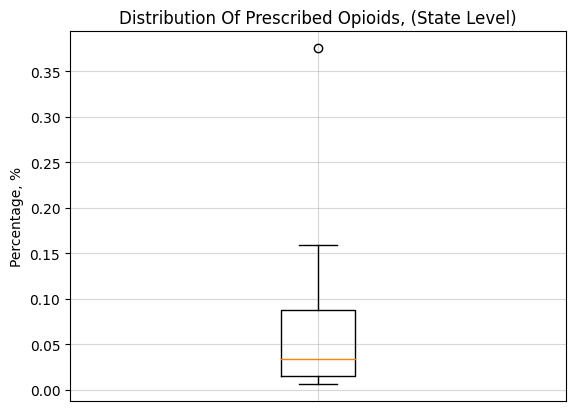

In [488]:
plt.boxplot(y)
plt.tick_params(bottom = False, labelbottom = False)
plt.title("Distribution Of Prescribed Opioids, (State Level)")
plt.ylabel("Percentage, %")
plt.grid(alpha = 0.5)


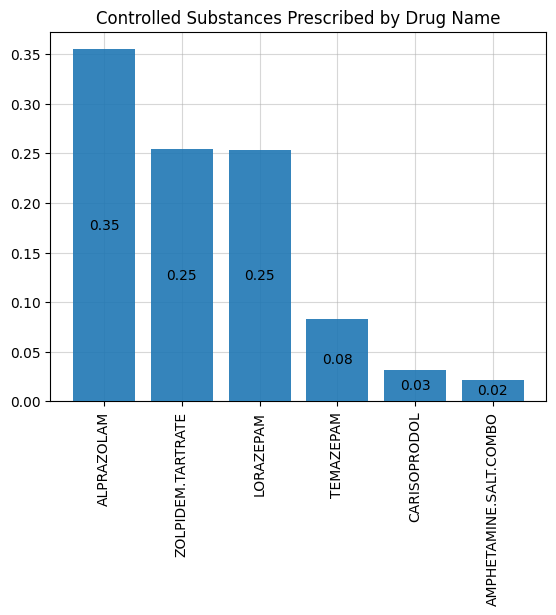

In [489]:
cntr = prescriber_df.iloc[:, meds_indicies[1] + 5:meds_indicies[2] + 5].sum().sort_values(ascending = False).reset_index()
cntr.columns = ["name", "quantity"]
cntr.loc[:, "ratio"] = cntr.loc[:, "quantity"] / sum(cntr.loc[:, "quantity"])
x = cntr.loc[:, "name"].to_list()
y = cntr.loc[:, "ratio"].to_list()

plt.bar(x, y, zorder = 5, alpha = 0.9)
plt.xticks(rotation = 90)
plt.title("Prescribed Controlled Substances by Drug Name")
plt.ylabel("Persantage, %")
addlabels(x, y, 2)
plt.grid(alpha = 0.5)

In [490]:
#using indecies of sorted col summarize them
#get start and end column names, define new column sum, update index
j = 0
opioid_col_names = ["not.opioid", "opioid", "controlled"]

for i in range(len(meds_indicies)):
  start_col, stop_col = p_cols_sorted[j], p_cols_sorted[meds_indicies[i]-1]
  prescriber_df[opioid_col_names[i]] = prescriber_df.loc[:, start_col: stop_col].apply("sum", axis=1)

  print(start_col, stop_col)
  j = meds_indicies[i]

ABILIFY DOXAZOSIN.MESYLATE
OXYCONTIN DIAZEPAM
AMPHETAMINE.SALT.COMBO ZOLPIDEM.TARTRATE


In [491]:
#subset values, change names of the columns
prescriber_df_select_cols = ["NPI", "Gender", "State", "Credentials", "Specialty", "Opioid.Prescriber"] + opioid_col_names
prescribeer_df_new_cols = pd.Series(prescriber_df_select_cols).apply(lambda s: s.lower()).to_list()
prescriber_df = prescriber_df[prescriber_df_select_cols].copy()
prescriber_df.columns = prescribeer_df_new_cols

In [492]:
prescriber_df.head()

,npi,gender,state,credentials,specialty,opioid.prescriber,not.opioid,opioid,controlled
0,1710982582,M,TX,DDS,Dentist,1,0,17,12
1,1245278100,F,AL,MD,General Surgery,1,779,398,241
2,1427182161,F,NY,M.D.,General Practice,0,221,24,44
3,1669567541,M,AZ,MD,Internal Medicine,1,1198,559,0
4,1679650949,M,NV,M.D.,Hematology/Oncology,1,101,66,12


In [493]:
#merge 2 dataframes
df = pd.merge(prescriber_df, overdose_df, on = "state")

#check value counts for overdose groups
#df["od.group"].value_counts().sort_index()

In [494]:
#generate 5 random indexes
# num_index = 5
# df_len = len(df)

# indexes_check  = (np.random.default_rng().random((num_index,)) * df_len).round().astype('int').tolist()

In [495]:
#df.iloc[indexes_check]

In [496]:
df.head()

,npi,gender,state,credentials,specialty,opioid.prescriber,not.opioid,opioid,controlled,state_full,pop,od,od.ratio,od.group
0,1710982582,M,TX,DDS,Dentist,1,0,17,12,Texas,26448193,2601,0.009834,C
1,1245278100,F,AL,MD,General Surgery,1,779,398,241,Alabama,4833722,723,0.014957,B
2,1427182161,F,NY,M.D.,General Practice,0,221,24,44,New York,19651127,2300,0.011704,B
3,1669567541,M,AZ,MD,Internal Medicine,1,1198,559,0,Arizona,6626624,1211,0.018275,B
4,1679650949,M,NV,M.D.,Hematology/Oncology,1,101,66,12,Nevada,2790136,545,0.019533,B


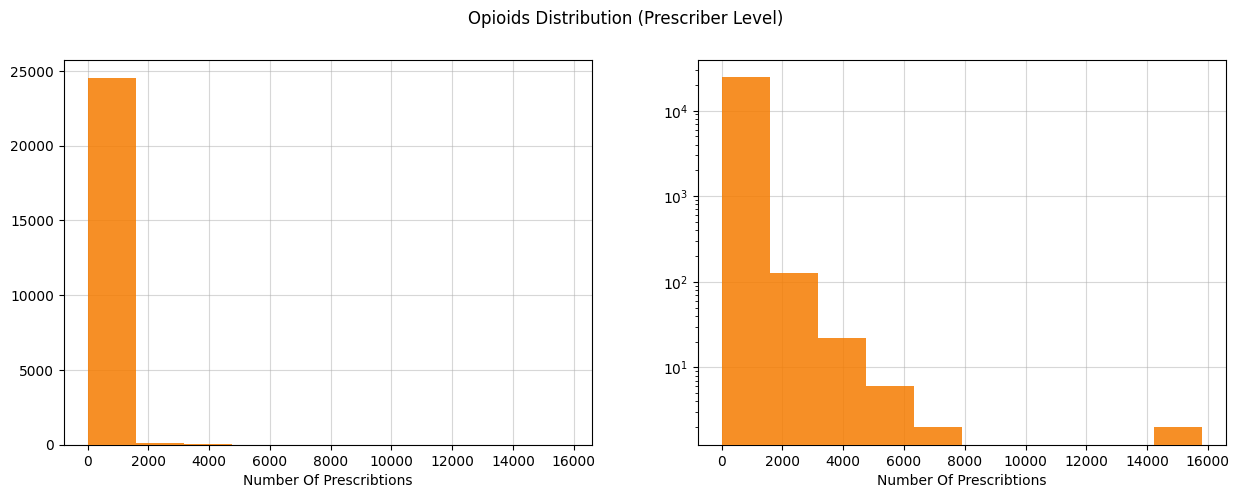

In [497]:
x = df.loc[:, "opioid"]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Opioids Distribution (Prescriber Level)")

ax[0].hist(x, color = "#f57c00", **hist_pars)
ax[0].set_xlabel("Number Of Prescribtions")
ax[0].grid(alpha = 0.5)

ax[1].hist(x, log = True, color = "#f57c00", **hist_pars)
ax[1].set_xlabel("Number Of Prescribtions")
ax[1].grid(alpha = 0.5)

In [498]:
#summary statistics, prescriber level, for the year
col_names = ["opioid", "controlled", "not.opioid"]
sum_stat1 = pd.concat([df[col_names[0]].describe().reset_index(), df[col_names[0]].agg(["median"]).reset_index()], ignore_index = True).set_index("index")
sum_stat2 = pd.concat([df[col_names[1]].describe().reset_index(), df[col_names[1]].agg(["median"]).reset_index()], ignore_index = True).set_index("index")
sum_stat3 = pd.concat([df[col_names[2]].describe().reset_index(), df[col_names[2]].agg(["median"]).reset_index()], ignore_index = True).set_index("index")

sum_stat1.join([sum_stat2, sum_stat3])

,opioid,controlled,not.opioid
index,,,
count,24680.000000,24680.000000,24680.000000
mean,102.274109,45.262561,1226.902836
std,315.436818,149.567949,2819.528502
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,32.000000
50%,14.000000,0.000000,151.000000
75%,75.000000,17.000000,1010.000000
max,15810.000000,9338.000000,53836.000000
median,14.000000,0.000000,151.000000


In [499]:
drugs_state_df = df.groupby("state")[col_names].agg("sum").join(overdose_df.drop("od.group", axis = 1).set_index("state"))

cols_order = ["state_full", "pop", "od", "od.ratio", "opioid", "controlled", "not.opioid"]

#drugs_state_df.head(1)
drugs_state_df = drugs_state_df.loc[:, cols_order]
#drugs_state_df.head(1)

In [500]:
drugs_state_df.describe()

,pop,od,od.ratio,opioid,controlled,not.opioid
count,5.000000e+01,50.000000,50.000000,50.000000,50.000000,5.000000e+01
mean,6.309648e+06,939.180000,0.015944,50482.500000,22341.600000,6.055992e+05
std,7.061295e+06,898.195486,0.005467,47907.425134,24584.502787,6.196546e+05
min,5.826580e+05,43.000000,0.005944,1499.000000,417.000000,1.409400e+04
25%,1.857857e+06,281.000000,0.012040,13133.250000,5055.000000,1.415798e+05
50%,4.510382e+06,712.000000,0.014906,36676.000000,13015.000000,3.856175e+05
75%,6.901760e+06,1209.750000,0.019121,71475.000000,29967.250000,7.809192e+05
max,3.833252e+07,4521.000000,0.033813,223722.000000,112920.000000,2.796825e+06


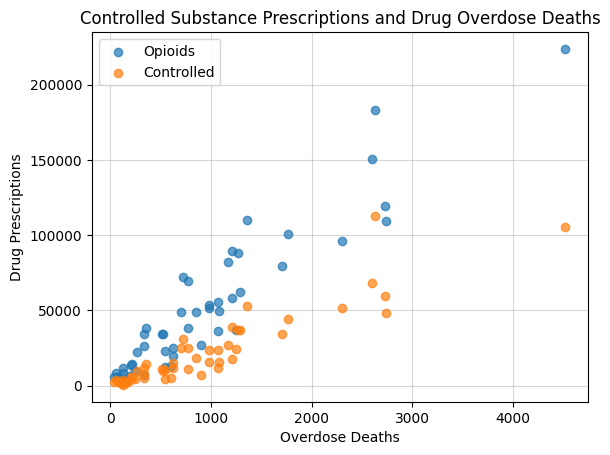

In [501]:
scatter_pars = {"alpha":0.7, "zorder": 5}

y1 = drugs_state_df.loc[:, "opioid"]
y2 = drugs_state_df.loc[:, "controlled"]
x = drugs_state_df.loc[:, "od"]
s = drugs_state_df.loc[:, "pop"] / sum(drugs_state_df.loc[:, "pop"]) * 1000

#state level
fig, ax = plt.subplots()

ax.scatter(x, y1, label = "Opioids", **scatter_pars)
ax.scatter(x, y2, label = "Controlled", **scatter_pars)
plt.title("Controlled Substance Prescriptions and Drug Overdose Deaths")
plt.legend()
plt.xlabel("Overdose Deaths")
plt.ylabel("Drug Prescriptions")
plt.grid(alpha = 0.5)
plt.show()

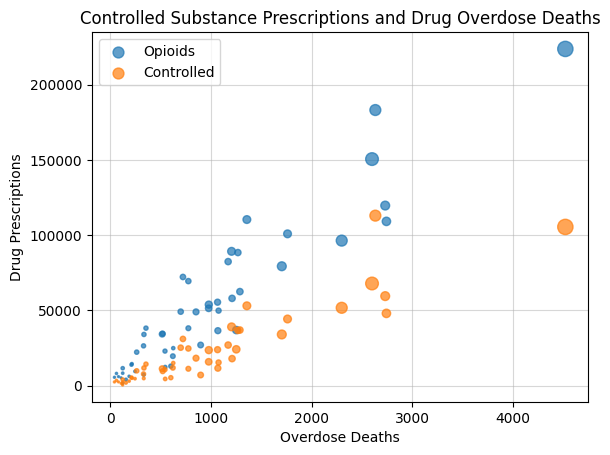

In [502]:
fig, ax = plt.subplots()

#with size as a population
ax.scatter(x, y1, s = s, label = "Opioids", **scatter_pars)
ax.scatter(x, y2, s = s, label = "Controlled", **scatter_pars)
plt.title("Controlled Substance Prescriptions and Drug Overdose Deaths")
plt.legend()
plt.xlabel("Overdose Deaths")
plt.ylabel("Drug Prescriptions")
plt.grid(alpha = 0.5)
plt.show()

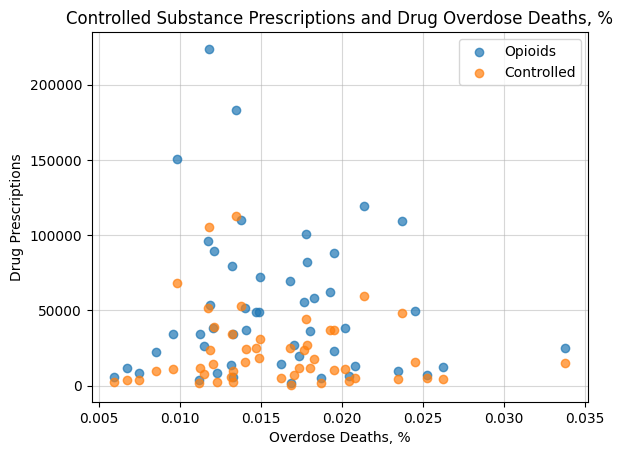

In [503]:
x = drugs_state_df.loc[:, "od.ratio"]

fig, ax = plt.subplots()

#state level
ax.scatter(x, y1, label = "Opioids", **scatter_pars)
ax.scatter(x, y2, label = "Controlled", **scatter_pars)
plt.title("Controlled Substance Prescriptions and Drug Overdose Deaths, %")
plt.legend()
plt.xlabel("Overdose Deaths, %")
plt.ylabel("Drug Prescriptions")
plt.grid(alpha = 0.5)
plt.show()

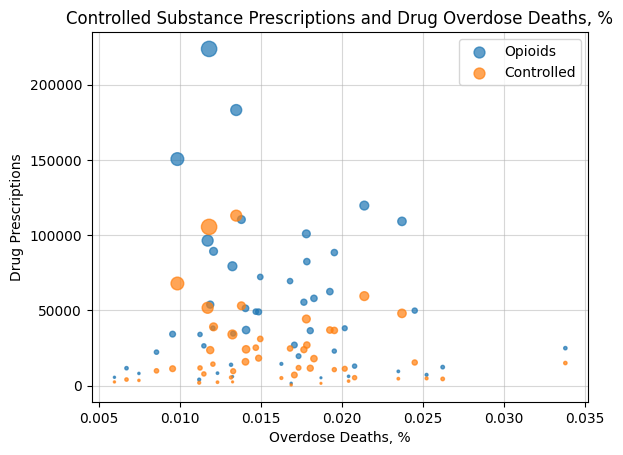

In [504]:
fig, ax = plt.subplots()

#with size as a population
ax.scatter(x, y1, s = s,  label = "Opioids", **scatter_pars)
ax.scatter(x, y2, s = s,  label = "Controlled", **scatter_pars)
plt.title("Controlled Substance Prescriptions and Drug Overdose Deaths, %")
plt.legend()
plt.xlabel("Overdose Deaths, %")
plt.ylabel("Drug Prescriptions")
plt.grid(alpha = 0.5)
plt.show()

In [505]:
#df.groupby("state")["opioid"].agg(["sum", "count"])

In [506]:
#test state group pairs if correct
#test1(df)

In [507]:
#subset columns
#similar dataset will be used to train the model
#sum column is generic and can be subsitution with different variations (opiods/non-opiods, etc)

# df_columns = ["credentials", "specialty", "opioid.prescriber"] + opioid_col_names + ["od.ratio", "od.group"]

# df = df.loc[:,df_columns]

# df.iloc[indexes_check]

In [508]:
#test_df = pd.DataFrame({"state":['NY'], "od_group":["A"]}) #incorrect group for NY state

#test1(test_df) #must raise an exception

In [509]:
# r = "od.ratio"
# drug = "controlled"

# fix, ax = plt.subplots()
# ax.scatter(df.loc[:, r], df.loc[:, drug] / df.loc[:, drug].sum())
# ax.set_xlabel(drug)
# ax.set_ylabel(r)